# CENTRALESUPELEC 2021-2022 - Intelligence Artificielle pour le Véhicule Autonome

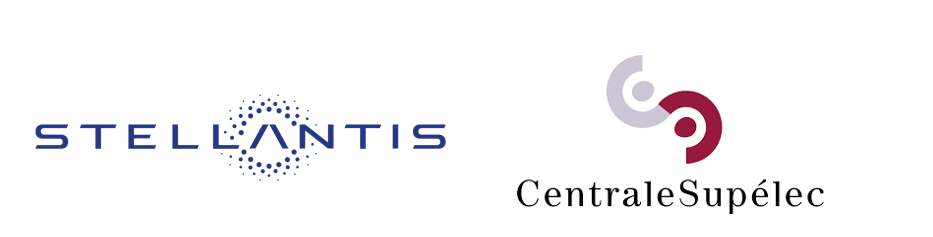

## Entrainement d'un réseau de neurones de classification pour le passage des feux tricolores.

L'objet de l'étude est d'entraîner un réseau qui, à partir de l'état dynamique du véhicule et de l'observation du feu tricolore devant lui, va décider dans quel mode ce véhicule doit se trouver. Le concepteur a défini 5 modes. Il s'agit donc de définir à chaque pas de temps quel est le bon mode. C'est un problème de classification.

L'entraînement retenu est un **apprentissage supervisé** qui va se dérouler en quatre étapes, auxquelles s'ajoute une étape de compréhension des phénomènes en jeu :

**1)** La phase de récolte des **données d'entraînement**, de **validation** et de **test**. Ces données seront constituées des entrées du réseau de neurones et de la vérité terrain (ground truth) associée à chaque vecteur d'entrée.

**2)** La phase de **préparation des données** pour les mettre dans un format adapté à l'outil d'entraînement de Keras

**3)** La phase **d'entraînement**

**4)** La phase de **test**

**5)** La phase de **synthèse et réflexions**

## 1) Récolte des données d'entrainement

Dans notre étude, on fait le choix de produire les données par simulation. 

On simule une voiture arrivant à une intersection protégée par un feu, et son comportement sera défini par un algorithme de machine d'état classique (cf. présentation). On enregistre à chaque pas de temps les paramètres souhaités.

On réalise N scénarios de simulations. On initialise aléatoirement en début de simulation les paramètres suivants : 

- **la vitesse** de la voiture au T0 de la simulaton
- **la couleur du feu** à ce T0, le temps écoulé depuis que le feu est passé à cette couleur 
- **la distance** à partir de laquelle la voiture verra la couleur du feu

Pour chacune de ces grandeurs, un tirage aléatoire de distribution uniforme est utilisé.

La vitesse initiale est tirée entre **6.1 et 13m/s**.
La distance de détection du feu est tirée entre **10 et 40m**.

Le résultat est un fichier au format *txt* où chaque ligne correspond à un pas de temps. 

Variables stockées sur une ligne :
- **la position** de notre ego car (en m)
- **la vitesse** de notre ego car (en m/s) 
- **l'accélération** de notre ego car (en m/s²)
- **l'état du feu au temps t-1** codé sur un vecteur 3 dimensions: (0,0,0): feu non détecté; (1,0,0): feu vert; (0,1,0): feu orange; (0,0,1): feu rouge
- **l'état du feu au temps t** codé sur un vecteur 3 dimensions
- **le mode de la machine d'état au temps t-1** codé sur un vecteur 5 dimensions (one-hot encoding)
- **le mode de la machine d'état au temps t** codé sur un vecteur 5 dimensions (one-hot encoding)

Les **14 premières variables** sont celles fournis en entrée du réseau pour **apprentissage**. Les **5 dernières** sont leur *ground truth* associée.

Le fichier ainsi généré se nomme selon **le nombre N**: *CS2021_BDD_N.txt*

## 2) Préparation des données pour l'entrainement

Afin de pouvoir les exploiter, il faut transférer ces données du fichier *txt* vers un tableau au format compatible avec la suite de nos travaux. Cette fonction est réalisée dans la fonction ***load_data***.

Cette fonction prend en entrée **le nom** du fichier texte duquel on souhaite extraire notre base de données, **la taille** de notre **vecteur d'entrée**, et **la taille** de notre **vecteur de sortie**.

Elle nous renvoie des tableaux contenant **nos valeurs d'entrées**, **les valeurs de sortie** associées ainsi que le **taille** de notre base de données.

Nous avons accès aux bases de données suivantes pour l'apprentissage:
- CS2021_TRAIN_1_GREEN.txt: une BDD générée lors d'un seul scénario, où le feu était vert au moment du passage.
- CS2021_TRAIN_1_RED.txt: une BDD générée lors d'un seul scénario, où le feu était rouge au moment du passage.
- CS2021_TRAIN_3.txt: une BDD générée sur la base de trois scénarios.
- CS2021_TRAIN_25.txt: une BDD générée sur la base de vingt-cinq scénarios.

Pour la validation, nous fixons une base de données pour tous les apprentissages pour nous permettre une comparaison cohérente, basée sur vingt-cinq scénarios, aux tirages différents de la base 25 scénarios utilisés pour les apprentissages:
- CS2021_VAL_25.txt: une BDD générée sur la base de vingt-cinq scénarios.

Vous serez amenez à modifier le nom de la base de données à charger pour l'apprentissage, sur la base du **tableau** présent en **fin de Notebook**.

***Exécutez la cellule suivante en utilisant MAJ+ENTER afin de charger les bases de données voulues***.

In [ ]:
import time
from utils import load_data

INPUT_SIZE = 14
OUTPUT_SIZE = 5

####################### TO UPDATE #######################

TrainDataName='CS2021_TRAIN_1_RED'

#########################################################

train_path = "data/"+TrainDataName+".txt"
TestDataName = "CS2021_VAL_25"

X_train, Y_train, TrainingSize = load_data(train_path, INPUT_SIZE, OUTPUT_SIZE)
X_val, Y_val, ValidationSize = load_data("data/" + TestDataName + ".txt", INPUT_SIZE, OUTPUT_SIZE)

print(f"\nTrain database {TrainDataName} with length = {TrainingSize}")
print(f"Validation database {TestDataName} with length = {ValidationSize}")


## 3-1) Phase d'entraînement - Construction du modèle

Avant d'entraîner le modèle, il faut définir en premier lieu l'architecture du réseau de neurones qui l'on souhaite utiliser. On décide ici de prendre un réseau ***MLP*** (*Multi layer perceptron*), avec une première couche de **64 neurones** et une fonction d'activation ***relu*** (*Rectified linear unit*), puis une deuxième couche de **32 neurones** avec une fonction d'activation ***relu***, et une couche de sortie de **5 neurones**, correspondant à la taille que nous souhaitons générer pour notre sortie. 

Pour l'entraînement on prendre une loss de type ***categorical_crossentropy*** adaptée aux problèmes de classification, avec un algorithme d'optimisation classique nommé *Adam Optimizer*. Doc et ref: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam.

Ce modèle est construit et compilé sous **Keras**, une librairie pour implémenter et entraîner facilement des réseaux de neurones. Cette librairie a été incluse dans la librairie **Tensorflow** (développée par Google) suite à l'embauche du fondateur de **Keras**, **François Chollet**. **Tensorflow** est une librairie plus complexe et complète, qui permet à la fois de créer facilement des réseaux de neurones, mais également d'avoir accès à des outils plus complets, comme **Tensorboard** que nous utiliseront pendant l'entraînement pour visualiser les performances de nos modèles en temps réels ou pour les comparer entre eux à posteriori.

***Exécutez la cellule suivante en utilisant MAJ+ENTER d'importer les librairies utiles pour la création de notre modèle, et pour charger en mémoire la fonction create_model***.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Model building

def create_model(learning_rate = 10e-4):
    
    model = Sequential()
    model.add(Dense(64, input_dim=INPUT_SIZE, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(OUTPUT_SIZE, activation='softmax'))

    # Model compilation

    opt_adam = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt_adam , metrics=['accuracy'])
    model.summary()
    
    return model


## 3-2) Phase d'entraînement - Visualisation par Tensorboard

**Tensorboard** est un outil très utilisé et pratique pour visualiser l'avancement des apprentissages en temps réelle, ou pour les comparer entre eux une fois les apprentissages terminés.

Au cours de l'apprentissage, un fichier *log* est enregistré dans le dossier *logs/fit*. Une fois la cellule exécutée, l'interface **Tensorboard** reste accessible en parallèle de l'éxécution d'autres cellules pour visualiser l'avancement de l'apprentissage par actualisation de l'interface.

Pour cette étude, nous ne nous intéresserons qu'à l'onglet ***scalar*** qui nous permet d'afficher les valeurs de ***loss*** et d'***accuracy*** pour les bases de ***train*** et de ***validation***. Vous pouvez à tout moment choisir les courbes que vous souhaitez afficher dans le menu déroulant en bas à gauche (*carrée* pour ajouter ou enlever de la sélection, *rond* pour tout déselectionner sauf celle-ci).

***Exécutez la cellule suivante en utilisant MAJ+ENTER de charger l'interface Tensorboard. Cette cellule n'est à exécuter qu'une seule fois. Il est ensuite possible d'actualiser les courbes en temps réel directement dans l'interface***.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="logs/fit" --host localhost --port 8088

## 3-3) Phase entraînement - Apprentissage

Nous allons, dans la cellule ci-dessous, lancer les apprentissages et optimiser notre réseau de neurones sur les bases de données que nous avons chargé précédemment *(cellule n°4)*.

Durant de TP, nous vous proposons de travailler sur trois ***hyperparamètres*** *(paramètres influant directement sur le processus d'apprentissage)*: le batch size, le nombre d'epoch ainsi que le learning rate. Ces hyperparamètres vont influencer la performance de l'apprentissage et celle du modèle obtenu. 

Ces hyperparamètres sont à la main du concepteur. Il est donc primordial de connnaître leurs impacts sur l'apprentissage afin de faire les meilleurs choix. Nous vous proposons ci-dessous de courtes définitions de ces trois hyperparamètres.

- **Batch size**: un batch est une **sous-partie** de notre base de données, de taille **batch size**, sur laquelle nous allons réaliser un pas d'optimisation *(calcul de notre fonction d'optimisation sur ce batch, moyenne sur le batch, calcul des gradients, optimisation des paramètres du modèle)*. Plus le batch est grand, plus le nombre d'exemples de notre base seront pris en compte pour le calcul de notre pas d'optimisation, et plus ce pas d'optimisation sera dans la direction de l'optimal recherché. 

- **Nombre d'epoch**: le nombre d'epoch est le nombre de fois où nous allons **parcourir** notre base de données dans son **entièreté** avant d'arrêter l'apprentissage.

- **Learning rate**: le learning rate est la **taille** du pas d'optimisation que nous choisissons d'appliquer après le calcul des gradients. Autrement dit, le learning rate vient impacter **l'amplitude des modifications** que l'on autorise sur les paramètres du modèle après chaque optimisation.

Prenez le temps de bien intégrer ces notions en complétant ces définitions par des recherches internet si nécessaire.

Ces trois hyperparamètres peuvent être modifiés dans l'encart ***TO UPDATE*** ci-dessous. Un tableau de valeur à tester vous est proposé à la fin de ce Notebook. Une fois les valeurs à tester choisi, exécutez la cellule d'apprentissage avec ***MAJ+ENTER***. La courbe correspondant à l'apprentissage apparaître dans l'interface **Tensorboard** après son actualisation, et le modèle sera automatique sauvegardé à la fin de l'apprentissage dans le dossier *models/*.

Le nom du modèle et du log **Tensorboard** est composé selon la logique suivante :

*"Nom_dataset + nombre d'epoch + taille de batch + learning rate + heure de l'apprentissage"*

Une fois ces notions assimilées, continuez et terminez la lecture du **Notebook** avant de lancer un apprentissage.

In [ ]:
#classes
from tensorflow.keras.callbacks import TensorBoard
import datetime

#Definition of batch and epoch sizes

####################### TO UPDATE #######################

batch_size = None
nb_epochs= None
learning_rate = None

##########################################################

#Preparation of logs registration for Tensorboard

time_date = datetime.datetime.now().strftime("%H%M%S")

ModelName = f"{TrainDataName}_epoch{nb_epochs}_batchsize{batch_size}_lr{learning_rate}_{time_date}"

log_dir = f"logs/fit/{ModelName}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create model

model = create_model(learning_rate)

#Training process

GoTrain=time.time()
model.fit(X_train, Y_train, epochs=nb_epochs, validation_data = (X_val, Y_val), batch_size=batch_size, verbose = 2, callbacks=[tensorboard_callback])
print(f"\n>>>>>>>>>>> Training completed in {(time.time() -GoTrain):.2f}s")

#Saving model

model.save("models/"+ModelName+".h5")
print(f"Model saved at ---> models/{ModelName}")

## 4-1) Test sur base de test

Une fois notre réseau entraîné, on calcule la performance du réseau sur une troisième base, qui n'est encore jamais intervenu lors de la phase d'apprentissage. On parle alors de **base de test**. C'est cette évaluation finale qui définira la performance du modèle, et qui nous permettra des les comparer les uns par rapport aux autres. 

Pour ce test, nous choisissons une base composée de 110 scénarios, plus grande que toutes celles utilisées jusque-là. Nous faisons ce choix afin d'avoir une évaluation de la performance de notre modèle la plus fine possible pour la pédagogie et la compréhension de l'impact des **hyperparamètres**. Bien entendu, dans un cas réel, la répartition des données disponibles entre bases de *TRAIN, VAL et TEST* est plutôt respectivement de l'ordre de *60% / 20% / 20%*.

***Exécutez la cellule suivante en utilisant MAJ+ENTER afin de charger la base de données de test***.

In [ ]:
# Load test dataset

TestDataSize='110'
TestDataName='CS2021_TEST_'+TestDataSize
test_path = "data/"+TestDataName+".txt"

X_test, Y_test, TestSize = load_data(test_path, INPUT_SIZE, OUTPUT_SIZE)

Une fois le modèle entraîné, nous utilisons une fonctionnalité Keras permettant d'évaluer le modèle sur la base de test.

***Exécutez la cellule suivante après chaque apprentissage réalisé.***

In [ ]:
from tensorflow.keras.models import load_model

#If necessary, you can load a model trained before using its name, by looking for it in the models/ folder.

model_to_test = ModelName + ".h5"
model = load_model("models/" + model_to_test)

#Model evaluation

test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=1024)
print(f"\n>>>>>>>>>>> {model_to_test} performances on test dataset: \n>>>>>>>>>>> Test Loss={test_loss:.4f}\n>>>>>>>>>>> Test Accuracy={test_acc:.4f}")

## 4-2) Test sur une simulation en boucle fermée

Nous travaillons ici sur un modèle ayant pour but de gérer le contrôle d'un véhicule lors de l'approche d'un feu de signalisation. Nous avons, jusqu'ici, travailler sur les performances du modèle en **boucle ouverte**. Nous avons comparé des instants de perception t de façon indépendante, sans tenir compte de la séquentialité de la tâche que l'on cherche à résoudre. Mais dans un cas où la sortie du modèle va influencer directement la sortie du véhicule, il est aussi important d'estimer la performance du modèle en **boucle fermée**.

On se propose dans les cellules suivantes de visualiser la simulation de l'approche d'un feu en utilisant en boucle fermé les décisions calculés par notre modèle.

Attention, cette cellule ouvre une fenêtre ***pygame*** qui à tendance à se mettre derrière la fenêtre du navigateur.

***Exécutez la cellule suivante après un apprentissage pour visualiser le comportement du modèle.***

In [ ]:
from utils import Sim_TFlight

#If necessary, you can load a model trained before using its name, by looking for it in the models/ folder.

model_to_test = ModelName + ".h5"
model = load_model("models/" + model_to_test)

#Set TFL_init to GREEN or RED to test these specific use cases. None is for a random initial state.

sim = Sim_TFlight(model, TFL_init=None) 

render = True
while render:
    sim.step()
    render = sim.render()

## 5) Discussion sur les hyperparamètres et la taille de la base de données

Afin d'imager et de forcer la compréhension de l'impact des hyperparamètres **nombre d'epoch, taille de batch et learning rate**, nous vous proposons de réaliser des apprentissages sur les quatre bases de *train* mis à votre disposition, en complétant le tableau de la cellule ci-dessous.

Chaque apprentissage correspond à une ligne du tableau, où les valeurs des colonnes correspondent respectivement à :

***Dataset name | Batch size | Number of epoch | Learning rate | Training time | Test DB accuracy | Comments on curves***

Au-delà de remplir les cases du tableaux, l'objectif ici est de comparer les différents comportements des apprentissages, de comprendre la notion ***d'overfitting*** et les impacts des différents ***hyperparamètres***.

Vous avez maintenant toutes les informations nécessaires pour la réalisation de ce TP. Vous pouvez maintenant commencer les apprentissages en modifiant et en exécutant les cellules de chargement de données, d'apprentissage, de test, etc...

***Exécutez la cellule suivante pour afficher le tableau.***

In [ ]:
####################### TO UPDATE #######################

# DB name, Batch size, Nb of epoch, Learning rate, Training time, Test DB acc, Comments on curves

result_table = {
    1:  ["1_RED",   64,   50, "10e-4", "...", "...", "..."], #Notes:
    2:  ["1_RED",   256,  50, "10e-4", "...", "...", "..."], #Notes:
    3:  ["1_RED",   1024, 50, "10e-4", "...", "...", "..."], #Notes:
    4:  ["1_GREEN", 1024, 50, "10e-4", "...", "...", "..."], #Notes:
    5:  ["3",       1024, 1,  "10e-4", "...", "...", "..."], #Notes:
    6:  ["3",       1024, 5,  "10e-4", "...", "...", "..."], #Notes:
    7:  ["3",       1024, 50, "10e-4", "...", "...", "..."], #Notes:
    8:  ["25",      1024, 50, "10e-7", "...", "...", "..."], #Notes:
    9:  ["25",      1024, 50, "10e-6", "...", "...", "..."], #Notes:
    10: ["25",      1024, 50, "10e-4", "...", "...", "..."]  #Notes:
}

##########################################################

print("{:<8} | {:<10} | {:<12} | {:<14} | {:<14} | {:<12} | {:<15}".format('DB name','Batch size', 'Nb of epoch', 'Learning rate', 'Training time', 'Test DB acc', 'Comments on curves'))
print("------------------------------------------------------------------------------------------------------------")
for k, v in result_table.items():
    
    DB_size, Batch_size, Epoch_size, Learning_rate, Training_time, Test_DB_accuracy, Comments = v
    
    print("{:<8} | {:<10} | {:<12} | {:<14} | {:<14} | {:<12} | {:<15}".format(DB_size, Batch_size, Epoch_size, Learning_rate, Training_time, Test_DB_accuracy, Comments))